In [1]:
from jaxl.constants import *
from jaxl.datasets import get_dataset
from jaxl.learning_utils import get_learner
from jaxl.plot_utils import set_size
from jaxl.utils import parse_dict

import jax
import json
import math
import numpy as np
import optax
import os

from orbax.checkpoint import PyTreeCheckpointer, CheckpointManager

In [2]:
base_dir = "/Users/chanb/research/personal/jaxl/jaxl"
learner_path = "/Users/chanb/research/personal/jaxl/jaxl/logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_20/gpt-pos_enc-09-09-23_19_18_47-0b5d21fd-3b77-42e3-93ed-4e62dfbe1321"
test_dataset_seed = 999

# For plotting
doc_width_pt = 452.9679

In [3]:
config_path = os.path.join(learner_path, "config.json")
with open(config_path, "r") as f:
    config_dict = json.load(f)
    config = parse_dict(config_dict)

learner = get_learner(
    config.learner_config, config.model_config, config.optimizer_config
)

checkpoint_manager = CheckpointManager(
    os.path.join(learner_path, "models"),
    PyTreeCheckpointer(),
)

params = checkpoint_manager.restore(checkpoint_manager.latest_step())
params[CONST_MODEL_DICT][CONST_MODEL][CONST_POSITIONAL_ENCODING] = dict()
model = learner._model

In [4]:
config.learner_config.dataset_config

namespace(dataset_name='multitask_nd_linear_classification',
          dataset_kwargs=namespace(input_dim=2,
                                   num_sequences=100000,
                                   sequence_length=41,
                                   noise=0.0,
                                   params_bound=[-10.0, 10.0],
                                   num_active_params=None,
                                   val_frac=0.0005),
          dataset_wrapper=namespace(type='ContextDataset',
                                    kwargs=namespace(context_len=20)))

In [5]:
sequence_len = 80
input_range = [-1.0, 1.0]
test_config = vars(config.learner_config.dataset_config)
test_config["dataset_kwargs"] = vars(test_config["dataset_kwargs"])
test_config["dataset_kwargs"]["num_sequences"] = 1
test_config["dataset_kwargs"]["sequence_length"] = sequence_len + 1
test_config["dataset_kwargs"]["params_bound"] = [-0.5, 0.5]
test_config["dataset_kwargs"]["inputs_range"] = input_range
ns_test_config = parse_dict(test_config)

In [6]:
test_dataset = get_dataset(ns_test_config, seed=test_dataset_seed)
unwrapped_dataset = test_dataset._dataset

In [7]:
test_dataset[0][3].shape

(2,)

In [8]:
print(unwrapped_dataset._inputs.shape, unwrapped_dataset._targets.shape)

(1, 81, 2) (1, 81, 2)


In [9]:
context_len = config.learner_config.dataset_config.dataset_wrapper.kwargs.context_len


def get_result(dataset, context_len):
    context_inputs, context_outputs = [], []
    for context_i in range(context_len):
        context_inputs.append(dataset._inputs[0, context_i])
        context_outputs.append(dataset._targets[0, context_i])
    context_inputs = np.stack(context_inputs)
    context_outputs = np.stack(context_outputs)

    queries = dataset._inputs[0, context_len:]
    outputs = dataset._targets[0, context_len:]

    preds, _ = jax.vmap(model.forward, in_axes=[None, 0, None])(
        params[CONST_MODEL_DICT][CONST_MODEL],
        queries[:, None, None],
        {
            CONST_CONTEXT_INPUT: context_inputs[None, :],
            CONST_CONTEXT_OUTPUT: context_outputs[None, :],
        },
    )
    return queries, preds, outputs, context_inputs, context_outputs

In [10]:
def ce_loss(logits, y_one_hot):
    return np.mean(optax.softmax_cross_entropy(logits, y_one_hot))

In [11]:
queries, preds, outputs, context_inputs, context_outputs = get_result(
    unwrapped_dataset, context_len
)
preds = preds[:, 0]
loss = ce_loss(preds, outputs)
print(queries.shape, preds.shape, outputs.shape)

(61, 2) (61, 2) (61, 2)


In [12]:
loss

Array(0.12675244, dtype=float32)

# Analysis

In [13]:
import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [14]:
gt = test_dataset.params[0]
gt_out = -np.array(input_range) * gt[1] / gt[2]

In [15]:
svm_regs = [1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0]
lr_regs = [1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0]

### SVM

In [16]:
def make_svm(inputs, outputs, reg_coef):
    svm = make_pipeline(
        LinearSVC(
            dual="auto",
            loss="hinge",
            random_state=0,
            tol=1e-7,
            C=reg_coef,
        ),
    )
    svm.fit(inputs, np.argmax(outputs, axis=1))
    return svm

/var/folders/h6/qs8bwp4d7bg67j4vbv960hdh0000gn/T/ipykernel_33307/69281506.py:66: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


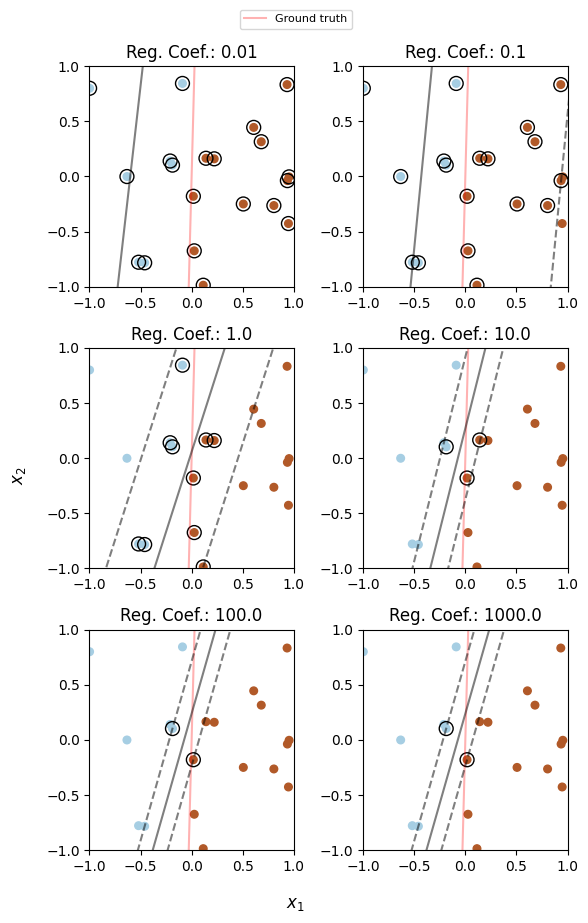

In [17]:
svms = {}

ncols = 2
nrows = math.ceil(len(svm_regs) / 2)
fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
    layout="constrained",
)

for idx, svm_reg in enumerate(svm_regs):
    if nrows == 1:
        ax = axes[idx]
    else:
        ax = axes[idx // 2, idx % 2]

    svms[svm_reg] = make_svm(context_inputs, context_outputs, svm_reg)

    decision_function = svms[svm_reg].decision_function(context_inputs)
    support_vector_indices = np.where(np.abs(decision_function) <= 1)[0]
    support_vectors = context_inputs[support_vector_indices]

    ax.plot(
        np.array(input_range),
        gt_out,
        label="Ground truth" if idx == 0 else "",
        color="red",
        alpha=0.3,
    )

    ax.scatter(
        context_inputs[:, 0],
        context_inputs[:, 1],
        c=context_outputs[:, -1],
        s=30,
        cmap=plt.cm.Paired,
    )
    DecisionBoundaryDisplay.from_estimator(
        svms[svm_reg],
        context_inputs,
        ax=ax,
        grid_resolution=50,
        plot_method="contour",
        colors="k",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )
    ax.scatter(
        support_vectors[:, 0],
        support_vectors[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )
    ax.set_xlim(input_range[0], input_range[1])
    ax.set_ylim(input_range[0], input_range[1])
    ax.set_title(f"Reg. Coef.: {svm_reg}")

fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=3,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8",
)
fig.supxlabel("$x_1$")
fig.supylabel("$x_2$")
plt.tight_layout()

### Logistic Regression

In [18]:
def make_lr(inputs, outputs, penalty, reg_coef):
    logistic_regression = make_pipeline(LogisticRegression(penalty=penalty, C=reg_coef))
    logistic_regression.fit(inputs, np.argmax(outputs, axis=1))
    return logistic_regression

/var/folders/h6/qs8bwp4d7bg67j4vbv960hdh0000gn/T/ipykernel_33307/175380336.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


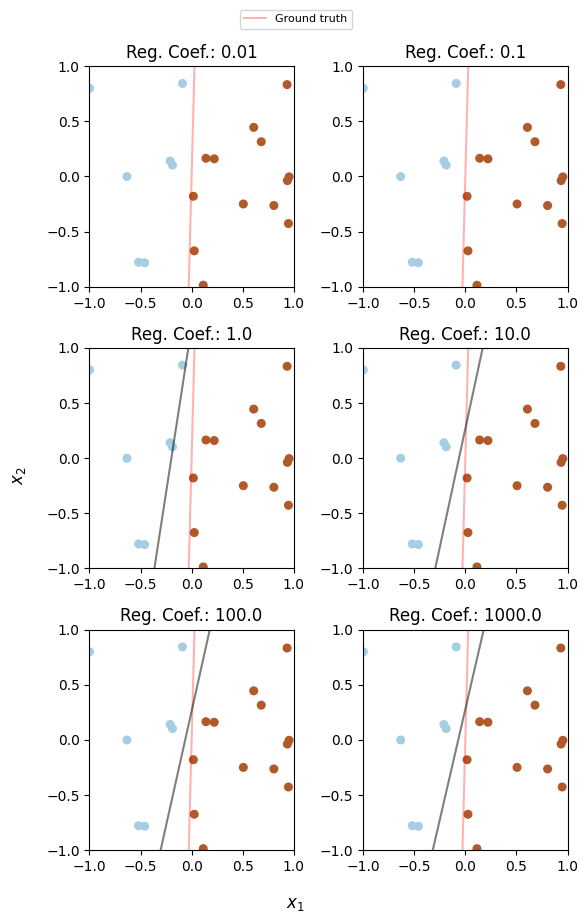

In [19]:
lrs = {}

ncols = 2
nrows = math.ceil(len(lr_regs) / 2)
fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
    layout="constrained",
)

for idx, lr_reg in enumerate(lr_regs):
    if nrows == 1:
        ax = axes[idx]
    else:
        ax = axes[idx // 2, idx % 2]

    ax.plot(
        np.array(input_range),
        gt_out,
        label="Ground truth" if idx == 0 else "",
        color="red",
        alpha=0.3,
    )

    lrs[lr_reg] = make_lr(context_inputs, context_outputs, "l2", lr_reg)
    ax.scatter(
        context_inputs[:, 0],
        context_inputs[:, 1],
        c=context_outputs[:, -1],
        s=30,
        cmap=plt.cm.Paired,
    )
    DecisionBoundaryDisplay.from_estimator(
        lrs[lr_reg],
        context_inputs,
        ax=ax,
        grid_resolution=50,
        plot_method="contour",
        colors="k",
        levels=[0],
        alpha=0.5,
        linestyles=["-"],
    )
    ax.set_xlim(input_range[0], input_range[1])
    ax.set_ylim(input_range[0], input_range[1])
    ax.set_title(f"Reg. Coef.: {lr_reg}")

fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=3,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8",
)
fig.supxlabel("$x_1$")
fig.supylabel("$x_2$")
plt.tight_layout()

### ICL Analysis

In [21]:
model_classes = {
    "SVM": svms,
    "LR": lrs,
}

num_models = sum([len(models) for models in (svms, lrs)])

delta = 0.01
xs_grid = np.arange(-1.0, 1.0 + delta, delta)
test_queries = np.stack(np.meshgrid(xs_grid, xs_grid)).reshape((2, -1)).T

In [22]:
llm_preds, _ = jax.vmap(model.forward, in_axes=[None, 0, None])(
    params[CONST_MODEL_DICT][CONST_MODEL],
    test_queries[:, None, None],
    {
        CONST_CONTEXT_INPUT: context_inputs[None, :],
        CONST_CONTEXT_OUTPUT: context_outputs[None, :],
    },
)
llm_preds = llm_preds[:, 0]

/var/folders/h6/qs8bwp4d7bg67j4vbv960hdh0000gn/T/ipykernel_33307/1478820211.py:55: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


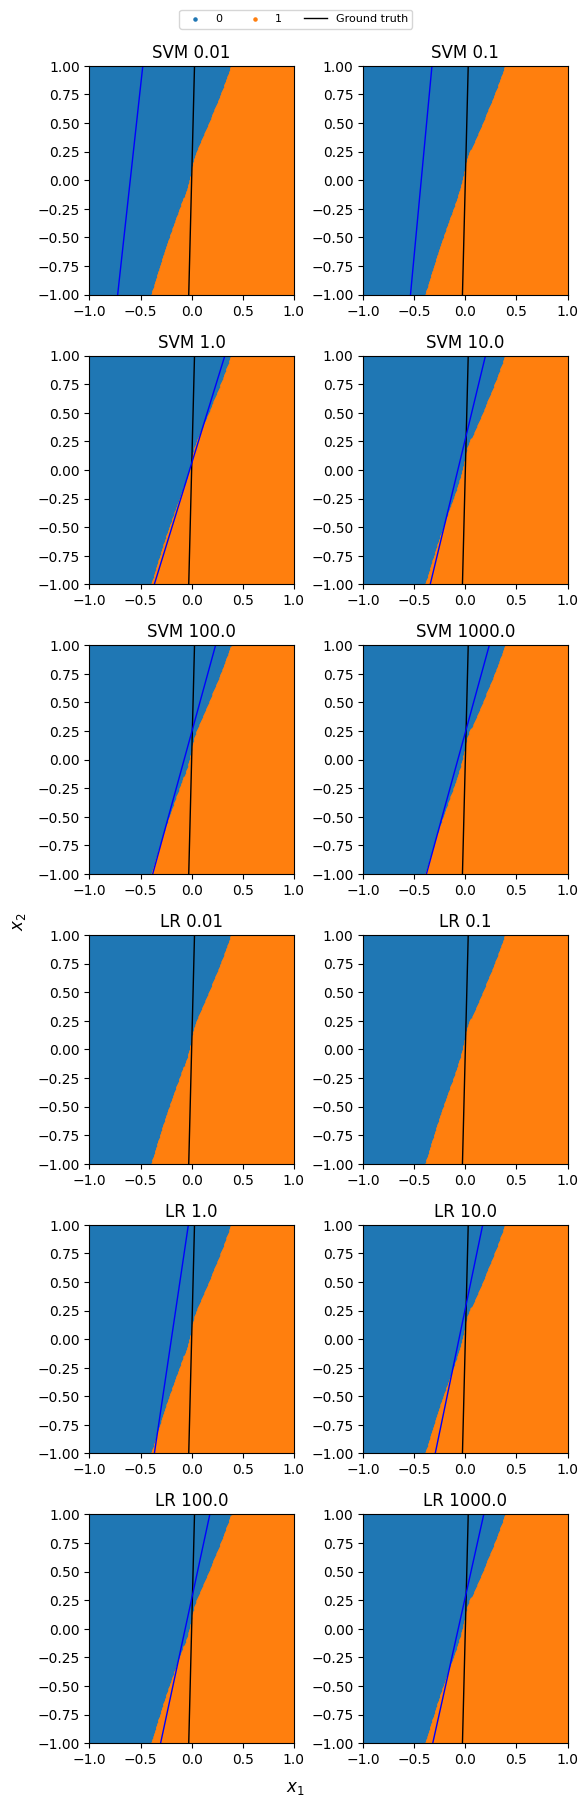

In [26]:
ncols = 2
nrows = math.ceil(num_models / 2)
fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
    layout="constrained",
)

model_i = 0
for model_class, models in model_classes.items():
    for reg_coef, model in models.items():
        model_out = (
            -(np.array(input_range) * model[0].coef_[0, 0] + model[0].intercept_[0])
            / model[0].coef_[0, 1]
        )

        if nrows == 1:
            ax = axes[model_i]
        else:
            ax = axes[model_i // 2, model_i % 2]

        llm_pred_labels = np.argmax(llm_preds, axis=-1)
        for possible_label in [0, 1]:
            idxes = np.where(llm_pred_labels == possible_label)
            ax.scatter(
                test_queries[idxes][:, 0],
                test_queries[idxes][:, 1],
                label=f"{possible_label}" if model_i == 0 else "",
                s=5,
            )

        ax.plot(
            np.array(input_range),
            gt_out,
            label="Ground truth" if model_i == 0 else "",
            color="black",
            linewidth=1,
        )

        ax.plot(np.array(input_range), model_out, color="blue", linewidth=1)

        ax.set_xlim(input_range[0], input_range[1])
        ax.set_ylim(input_range[0], input_range[1])
        ax.set_title(f"{model_class} {reg_coef}")
        model_i += 1


fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=3,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8",
)
fig.supxlabel("$x_1$")
fig.supylabel("$x_2$")
plt.tight_layout()

### Mean-squared Prediction Difference